<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
print(sklearn.__version__)

1.3.2


### Evaluation of Base Models over Range of Thresholds

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from loan_data_utils import load_and_preprocess_data
import json

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and preprocess data (assuming this function is defined)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define candidate models
candidate_models = {
    'LogReg': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'HGB': HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# Create pipelines for each candidate model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in candidate_models.items()}

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[y_proba[:, 1] >= threshold_class_1] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[y_proba[:, 0] >= threshold_class_0] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Function to evaluate models with multiple thresholds
def evaluate_models_with_multiple_thresholds(pipelines, X_train, y_train, X_test, y_test, thresholds_class_1, thresholds_class_0):
    results = []
    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        for threshold_class_1 in thresholds_class_1:
            for threshold_class_0 in thresholds_class_0:
                y_pred = predict_with_class_specific_thresholds(pipeline, X_test, threshold_class_1, threshold_class_0)
                recall_1 = recall_score(y_test, y_pred, pos_label=1)
                precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
                recall_0 = recall_score(y_test, y_pred, pos_label=0)
                precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
                f1_macro = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
                results.append({
                    'Model': name,
                    'Threshold Class 1': threshold_class_1,
                    'Threshold Class 0': threshold_class_0,
                    'Recall Class 1': recall_1,
                    'Precision Class 1': precision_1,
                    'Recall Class 0': recall_0,
                    'Precision Class 0': precision_0,
                    'F1 Macro': f1_macro
                })
    return pd.DataFrame(results)

# Define the range of thresholds to test
thresholds_class_1 = np.arange(0.2, 0.5, 0.05)
thresholds_class_0 = np.arange(0.2, 0.5, 0.05)

# Evaluate candidate models with multiple thresholds
evaluation_results_multiple_thresholds = evaluate_models_with_multiple_thresholds(pipelines, X_train, y_train, X_test, y_test, thresholds_class_1, thresholds_class_0)

# Find the best threshold combination for each model based on F1 Macro score
best_thresholds = evaluation_results_multiple_thresholds.loc[evaluation_results_multiple_thresholds.groupby('Model')['F1 Macro'].idxmax()]

# Save the best threshold combinations to a JSON file
best_thresholds_dict = best_thresholds.to_dict(orient='records')
with open('best_thresholds.json', 'w') as json_file:
    json.dump(best_thresholds_dict, json_file, indent=4)

print("Best threshold combinations saved to 'best_thresholds.json'")
print("Best threshold combinations for each model:")
best_thresholds

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best threshold combinations saved to 'best_thresholds.json'
Best threshold combinations for each model:


,Model,Threshold Class 1,Threshold Class 0,Recall Class 1,Precision Class 1,Recall Class 0,Precision Class 0,F1 Macro
113,HGB,0.2,0.45,0.571967,0.512492,0.845495,0.874308,0.540598
77,LGBM,0.2,0.45,0.573474,0.502974,0.839076,0.873858,0.535915
5,LogReg,0.2,0.45,0.525998,0.469401,0.831158,0.860625,0.496091
41,RF,0.2,0.45,0.296157,0.674099,0.959341,0.827580,0.411518


### Best Threshold Combinations

### Select & Tune Models

In [ ]:
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
import joblib
import json

# Custom scorers for recall and precision for class 0 and class 1
scorers = {
    'recall_class_1': make_scorer(recall_score, pos_label=1),
    'precision_class_1': make_scorer(precision_score, pos_label=1),
    'recall_class_0': make_scorer(recall_score, pos_label=0),
    'precision_class_0': make_scorer(precision_score, pos_label=0)
}

# Function to perform grid search for a given model
def tune_model(pipeline, param_grid, X_train, y_train, scoring):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)
    return grid_search

# Load the best threshold combinations
with open('best_thresholds.json', 'r') as json_file:
    best_thresholds = json.load(json_file)
best_thresholds_df = pd.DataFrame(best_thresholds)

# Function to tune and save models
def tune_and_save_models(pipelines, param_grids, X_train, y_train, best_thresholds_df, scorers, models_file, params_file):
    best_models = {}
    best_params = {}

    for metric, scorer in scorers.items():
        if 'recall' in metric:
            class_num = metric.split('_')[-1]
            model_name = best_thresholds_df.loc[best_thresholds_df[f'Recall Class {class_num}'].idxmax(), 'Model']
        else:
            class_num = metric.split('_')[-1]
            model_name = best_thresholds_df.loc[best_thresholds_df[f'Precision Class {class_num}'].idxmax(), 'Model']

        tuned_model = tune_model(pipelines[model_name], param_grids[model_name], X_train, y_train, scoring=scorer)

        best_models[metric] = tuned_model.best_estimator_
        best_params[metric] = tuned_model.best_params_

    # Save the best models
    joblib.dump(best_models, models_file, protocol=4)
    print(f"Best models saved to '{models_file}'")

    # Save the best parameters
    with open(params_file, 'w') as json_file:
        json.dump(best_params, json_file, indent=4)
    print(f"Best parameters saved to '{params_file}'")

    return best_models, best_params

# Define parameter grids for the selected models
param_grids = {
    'LogReg': {'classifier__C': [0.1, 1, 10]},
    'RF': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]},
    'LGBM': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1], 'classifier__force_row_wise': [True]},
    'HGB': {'classifier__max_iter': [100, 200], 'classifier__learning_rate': [0.01, 0.1]}
}

# Define scoring metrics using custom scorers
scoring_metrics = ['recall_class_1', 'precision_class_1', 'recall_class_0', 'precision_class_0']

# File names for saving the best models and parameters
models_file = 'best_models.pkl'
params_file = 'best_params.json'

# Tune and save models
best_models, best_params = tune_and_save_models(pipelines, param_grids, X_train, y_train, best_thresholds_df, scorers, models_file, params_file)

# Print the best parameters
for metric, params in best_params.items():
    print(f"Best parameters for {metric}: {params}")


[LightGBM] [Info] Number of positive: 4248, number of negative: 14952
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Total Bins 3272
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM

In [ ]:
# Print the best models and their parameters for each metric
print("Best models and their parameters for each metric:")

for metric, model in best_models.items():
    model_name = model.named_steps['classifier'].__class__.__name__
    print(f"\nBest model for {metric}: {model_name}")
    print("Best parameters:")
    for param, value in best_params[metric].items():
        print(f"  {param}: {value}")


Best models and their parameters for each metric:

Best model for recall_class_1: LGBMClassifier
Best parameters:
  classifier__force_row_wise: True
  classifier__learning_rate: 0.01
  classifier__n_estimators: 200

Best model for precision_class_1: RandomForestClassifier
Best parameters:
  classifier__max_depth: 20
  classifier__n_estimators: 200

Best model for recall_class_0: RandomForestClassifier
Best parameters:
  classifier__max_depth: 20
  classifier__n_estimators: 200

Best model for precision_class_0: HistGradientBoostingClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__max_iter: 100


#### Save Model Files

File is 181 MB so reduction in size is needed

In [9]:
import joblib
import json

# Save the essential information of the best models
best_models_info = {
    'recall_class_1': best_models['recall_class_1'].named_steps['classifier'].__class__.__name__,
    'precision_class_1': best_models['precision_class_1'].named_steps['classifier'].__class__.__name__,
    'recall_class_0': best_models['recall_class_0'].named_steps['classifier'].__class__.__name__,
    'precision_class_0': best_models['precision_class_0'].named_steps['classifier'].__class__.__name__,
    'best_params': best_params
}

# Save the best models information to a JSON file
best_models_info_file = 'best_models_info.json'
with open(best_models_info_file, 'w') as json_file:
    json.dump(best_models_info, json_file, indent=4)
print(f"Best models information saved to '{best_models_info_file}'")


Best models information saved to 'best_models_info.json'


In [10]:

# Load the best models information from the JSON file
with open('best_models_info.json', 'r') as json_file:
    best_models_info = json.load(json_file)

# Print out the contents of the JSON file
print(json.dumps(best_models_info, indent=4))

{
    "recall_class_1": "LGBMClassifier",
    "precision_class_1": "RandomForestClassifier",
    "recall_class_0": "RandomForestClassifier",
    "precision_class_0": "HistGradientBoostingClassifier",
    "best_params": {
        "recall_class_1": {
            "classifier__force_row_wise": true,
            "classifier__learning_rate": 0.01,
            "classifier__n_estimators": 200
        },
        "precision_class_1": {
            "classifier__max_depth": 20,
            "classifier__n_estimators": 200
        },
        "recall_class_0": {
            "classifier__max_depth": 20,
            "classifier__n_estimators": 200
        },
        "precision_class_0": {
            "classifier__learning_rate": 0.1,
            "classifier__max_iter": 100
        }
    }
}


### Create Meta-Model - Voting & Stacking Classifiers

In [ ]:
import joblib
import json
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

# Load the best models and parameters
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# Load the best thresholds
with open('best_thresholds.json', 'r') as json_file:
    best_thresholds = json.load(json_file)

# Extract the optimal thresholds
THRESHOLD_CLASS_1 = best_thresholds[0]['Threshold Class 1']
THRESHOLD_CLASS_0 = best_thresholds[0]['Threshold Class 0']

# Create a list of (name, model) tuples for the VotingClassifier and StackingClassifier
estimators = [
    ('recall_class_1', best_models['recall_class_1']),
    ('precision_class_1', best_models['precision_class_1']),
    ('recall_class_0', best_models['recall_class_0']),
    ('precision_class_0', best_models['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Initialize the StackingClassifier with the best models
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the classifiers on the training data
voting_clf.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[y_proba[:, 1] >= threshold_class_1] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[y_proba[:, 0] >= threshold_class_0] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Predict with the VotingClassifier
y_pred_voting = predict_with_class_specific_thresholds(voting_clf, X_test, THRESHOLD_CLASS_1, THRESHOLD_CLASS_0)

# Predict with the StackingClassifier
y_pred_stacking = predict_with_class_specific_thresholds(stacking_clf, X_test, THRESHOLD_CLASS_1, THRESHOLD_CLASS_0)

# Evaluate the performance of the VotingClassifier
recall_1_voting = recall_score(y_test, y_pred_voting, pos_label=1)
precision_1_voting = precision_score(y_test, y_pred_voting, pos_label=1, zero_division=0)
recall_0_voting = recall_score(y_test, y_pred_voting, pos_label=0)
precision_0_voting = precision_score(y_test, y_pred_voting, pos_label=0, zero_division=0)
f1_macro_voting = f1_score(y_test, y_pred_voting, average='macro')

# Evaluate the performance of the StackingClassifier
recall_1_stacking = recall_score(y_test, y_pred_stacking, pos_label=1)
precision_1_stacking = precision_score(y_test, y_pred_stacking, pos_label=1, zero_division=0)
recall_0_stacking = recall_score(y_test, y_pred_stacking, pos_label=0)
precision_0_stacking = precision_score(y_test, y_pred_stacking, pos_label=0, zero_division=0)
f1_macro_stacking = f1_score(y_test, y_pred_stacking, average='macro')

# Print the evaluation metrics for VotingClassifier
print("\nVotingClassifier Performance:")
print(f'Recall Class 1: {recall_1_voting:.4f}')
print(f'Precision Class 1: {precision_1_voting:.4f}')
print(f'Recall Class 0: {recall_0_voting:.4f}')
print(f'Precision Class 0: {precision_0_voting:.4f}')
print(f'F1 Macro: {f1_macro_voting:.4f}')
print("\nClassification Report for VotingClassifier:\n")
print(classification_report(y_test, y_pred_voting))

# Print the evaluation metrics for StackingClassifier
print("\nStackingClassifier Performance:")
print(f'Recall Class 1: {recall_1_stacking:.4f}')
print(f'Precision Class 1: {precision_1_stacking:.4f}')
print(f'Recall Class 0: {recall_0_stacking:.4f}')
print(f'Precision Class 0: {precision_0_stacking:.4f}')
print(f'F1 Macro: {f1_macro_stacking:.4f}')
print("\nClassification Report for StackingClassifier:\n")
print(classification_report(y_test, y_pred_stacking))

# Save the final VotingClassifier and StackingClassifier models
joblib.dump(voting_clf, 'best_voting_classifier.pkl')
joblib.dump(stacking_clf, 'best_stacking_classifier.pkl')


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4248, number of negative: 14952
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [I

['best_stacking_classifier.pkl']

### Voting & Stacking Classifiers Model Comparison


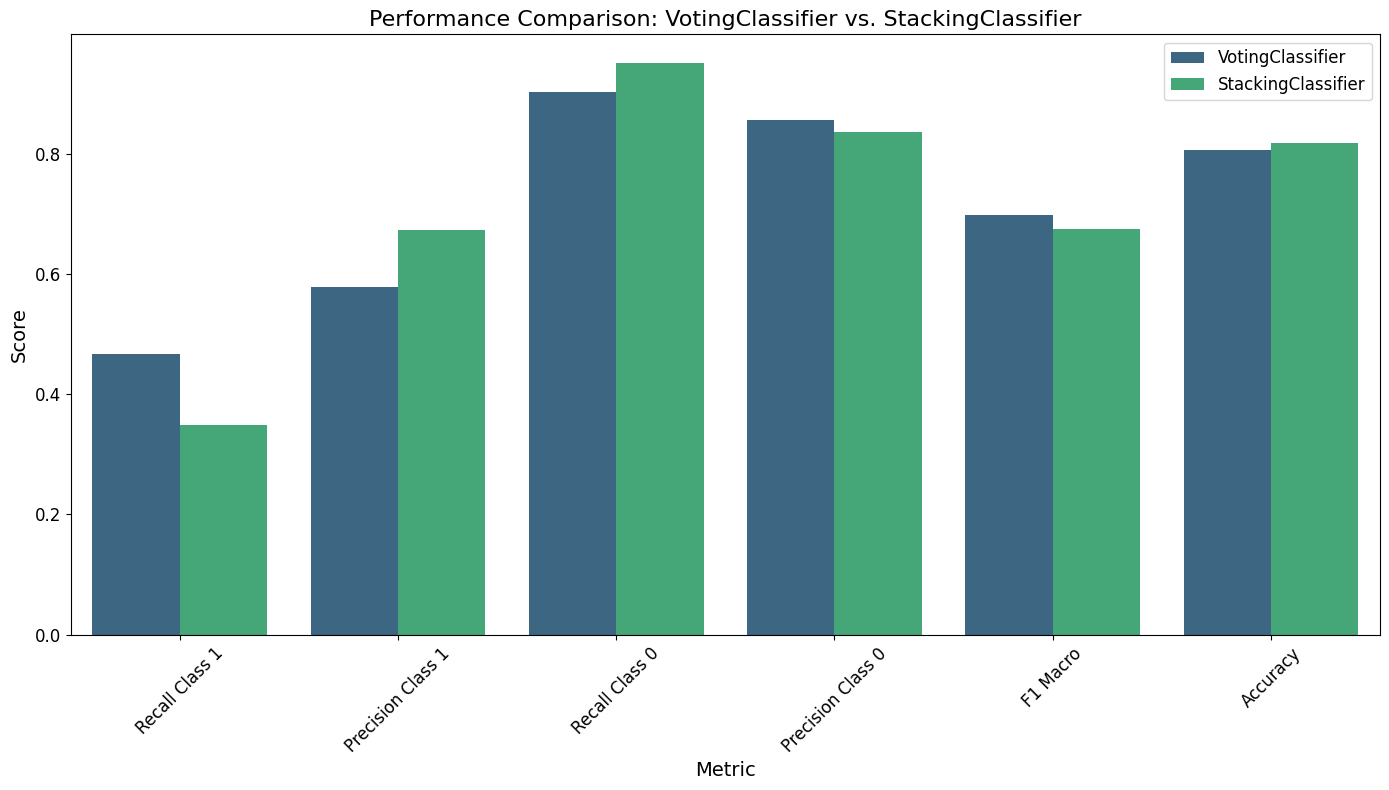

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Calculate accuracy for both models
accuracy_voting = accuracy_score(y_test, y_pred_voting)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

# Combine the results into a DataFrame
results = pd.DataFrame({
    'Metric': ['Recall Class 1', 'Precision Class 1', 'Recall Class 0', 'Precision Class 0', 'F1 Macro', 'Accuracy'],
    'VotingClassifier': [recall_1_voting, precision_1_voting, recall_0_voting, precision_0_voting, f1_macro_voting, accuracy_voting],
    'StackingClassifier': [recall_1_stacking, precision_1_stacking, recall_0_stacking, precision_0_stacking, f1_macro_stacking, accuracy_stacking]
})

# Set the Metric column as the index
results.set_index('Metric', inplace=True)

# Plot the results
plt.figure(figsize=(14, 8))
sns.barplot(data=results.reset_index().melt(id_vars='Metric', var_name='Model', value_name='Score'),
            x='Metric', y='Score', hue='Model', palette='viridis')

plt.title('Performance Comparison: VotingClassifier vs. StackingClassifier', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
results

,VotingClassifier,StackingClassifier
Metric,,
Recall Class 1,0.467973,0.348907
Precision Class 1,0.579291,0.673945
Recall Class 0,0.903488,0.952065
Precision Class 0,0.856737,0.837380
F1 Macro,0.698604,0.675414
Accuracy,0.807167,0.818667


Given the primary goal of achieving high recall for class 1 (loan defaults), along with high precision and F1 scores for class 1, here’s the interpretation of the results for both the VotingClassifier and StackingClassifier:

### Recall for Class 1 (Loan Defaults)
- **VotingClassifier: 0.468**
- **StackingClassifier: 0.349**

The VotingClassifier achieves a significantly higher recall for class 1 compared to the StackingClassifier. Recall is crucial for identifying loan defaults, so the VotingClassifier is better in this aspect.

### Precision for Class 1 (Loan Defaults)
- **VotingClassifier: 0.579**
- **StackingClassifier: 0.674**

The StackingClassifier has higher precision for class 1, indicating that when it predicts a loan default, it is more likely to be correct. However, the recall is quite low, meaning it misses many actual loan defaults.

### Recall for Class 0 (Non-Defaults)
- **VotingClassifier: 0.903**
- **StackingClassifier: 0.952**

The StackingClassifier performs better in recalling class 0, which means it is better at identifying non-defaults. However, this is not the primary goal.

### Precision for Class 0 (Non-Defaults)
- **VotingClassifier: 0.857**
- **StackingClassifier: 0.837**

Both models have similar precision for class 0, with the VotingClassifier being slightly better.

### F1 Macro Score
- **VotingClassifier: 0.699**
- **StackingClassifier: 0.675**

The VotingClassifier has a slightly higher F1 Macro score, which considers both precision and recall for both classes. This indicates a better overall balance between precision and recall across classes.

### Accuracy
- **VotingClassifier: 0.807**
- **StackingClassifier: 0.819**

The StackingClassifier has a slightly higher accuracy, but accuracy is not the best metric for imbalanced datasets and is less important given the primary goal.

### Conclusion
- The **VotingClassifier** is preferred because it has a much higher recall for class 1, which is the primary goal. This means it identifies more actual loan defaults, despite having lower precision.
- The **StackingClassifier** has better precision for class 1, but its recall is significantly lower, which means it misses more actual loan defaults.

### Recommendation
Given the primary objective of identifying loan defaults, the VotingClassifier should be used. However, there is a trade-off between recall and precision. If higher precision is also crucial, further tuning of the thresholds or exploring additional ensemble methods might be necessary to improve both recall and precision for class 1.

### Next Steps

With the baseline model established, the next steps should focus on further improving the performance, particularly targeting the recall for class 1 (loan defaults) while maintaining or improving precision and F1 scores. Here are some recommended steps:

### 1. **Hyperparameter Tuning**
Fine-tune the hyperparameters of the best-performing models within the VotingClassifier to further optimize performance.

### 2. **Feature Engineering**
- **Create new features** that might capture more information about the data.
- **Interaction terms**: Create features that capture interactions between existing features.
- **Polynomial features**: Experiment with polynomial features for non-linear relationships.

### 3. **Model Ensembling Techniques**
- **Blend different models**: Try combining models in various ways, such as using the average of their predictions.
- **Bagging and Boosting**: Implement bagging (e.g., BaggingClassifier) and boosting (e.g., XGBoost, AdaBoost) to see if these techniques improve performance.

### 4. **Advanced Resampling Techniques**
- **SMOTE (Synthetic Minority Over-sampling Technique)**: Generate synthetic samples for the minority class to balance the dataset.
- **ADASYN (Adaptive Synthetic Sampling)**: A variation of SMOTE that focuses on harder-to-learn examples.
- **Combination of under-sampling and over-sampling**: Use methods like SMOTE combined with under-sampling of the majority class.

### 5. **Threshold Tuning**
- **Fine-tune the classification thresholds** further. You might want to run a more granular search for the optimal thresholds for both classes.

### 6. **Stacking Classifier Optimization**
- **Improve the meta-model**: Try different algorithms as the final estimator in the stacking classifier. For example, you could use a more complex model like a gradient boosting machine (GBM) or a neural network.

### 7. **Cross-Validation and Robustness Checks**
- **K-Fold Cross-Validation**: Perform k-fold cross-validation to ensure the robustness of the model.
- **Check for overfitting**: Ensure that the model is not overfitting by comparing the performance on training and validation sets.

### 8. **Model Interpretability**
- **Feature importance**: Analyze the importance of features in the model to understand which features are contributing the most.
- **SHAP (SHapley Additive exPlanations)**: Use SHAP values to get more detailed insights into model predictions.

### 9. **Model Deployment Considerations**
- **Model stability and performance in production**: Simulate or test the model in a production-like environment.
- **Monitoring and maintenance**: Set up monitoring for model performance and have a plan for periodic retraining as new data comes in.

